In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

import numpy as np
import cv2
import youtube_dl
import pafy
from io import BytesIO
import PIL
from PIL import ImageDraw
import IPython
import time

from hubconf import detr_resnet50
from util.box_ops import box_cxcywh_to_xyxy

In [2]:
model = detr_resnet50(pretrained=True)
model.eval();
model = model.to('cuda');

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
# url = 'https://uhdwallpapers.org/uploads/converted/18/11/05/super-photo-with-nazare-beach-portugal-3840x2400_55954-mm-90.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# w, h = im.size
# im = im.resize((w // 4, h // 4))

# scores, boxes = detect(im, model, transform)

In [6]:
# !pip install youtube_dl pafy opencv

In [7]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
#     PIL.Image.fromarray(a).save(f, fmt)
    a.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    IPython.display.clear_output(wait=True)
    
def draw_results(draw, prob, boxes):    
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        draw.rectangle((xmin, ymin, xmax, ymax), outline=tuple([int(cc * 255) for cc in c]))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        draw.text((xmin, ymin), text)

In [8]:
def detect(im, model, transform):
    img = transform(im).unsqueeze(0)
    img = img.to('cuda')
    
    # propagate through the model
    outputs = model(img)
    
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
        
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep].cpu(), im.size)
    return probas[keep], bboxes_scaled

In [12]:
# url = "https://www.youtube.com/watch?v=mRe-514tGMg" # Times square
url = "https://www.youtube.com/watch?v=1pf1qjYpHlY&list=PLwygboCFkeeA2w1fzJm44swdG-NnyB6ip&index=2"
# url = 'https://www.youtube.com/watch?v=aSyipwo0BzA'
urlPafy = pafy.new(url)
urlPafy.streams

[normal:mp4@256x144,
 normal:mp4@426x240,
 normal:mp4@640x360,
 normal:mp4@854x480,
 normal:mp4@1280x720]

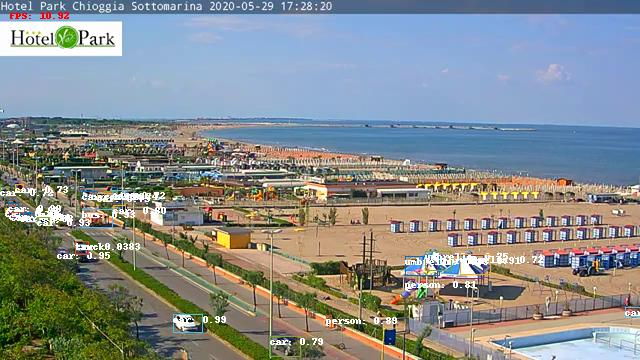

In [ ]:
cap = cv2.VideoCapture(urlPafy.streams[2].url)
# cap.set(cv2.CAP_PROP_BUFFERSIZE, 100)

last_time = time.time()
frame_count = 0
fps = 0

for i in range(1000):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    td = time.time() - last_time
    
    if td > 1:
        fps = frame_count / td
        last_time = last_time + td
        frame_count = 0
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)      
    frame = Image.fromarray(frame)
    
    draw = ImageDraw.Draw(frame)
    
    scores, boxes = detect(frame, model, transform)
    draw_results(draw, scores, boxes)
    
    draw.text([10, 10], 'FPS: {:.2f}'.format(fps), fill=(255, 0, 0))
    showarray(frame)
    frame_count += 1
    

# When everything done, release the capture
cap.release()